# PyMC and Universal Samplers

## Part A: `import pymc`

In [ ]:
import pymc

- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)
- [Example Gallary](https://www.pymc.io/projects/examples/en/latest/gallery.html)

In [ ]:
print(f"Running on PyMC v{pymc.__version__}")

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 设置参数
n = 100  # Sample size（样本量）
true_theta, true_tau = 0, 1  # 数据生成机制的真实参数：true_theta（均值）和 true_tau（精度）

# 数据生成机制（Data Generating Mechanism）
# 基于正态分布，loc = true_theta（均值），scale = true_tau^(-0.5)（标准差，tau 的倒数平方根）
data_generating_mechanism = stats.norm(loc=true_theta, scale=true_tau**(-0.5))

# 从数据生成机制中采样 n 个数据点
x = data_generating_mechanism.rvs(size=n)

# 绘制数据的直方图（Histogram）
plt.hist(x, density=True)  # density=True 表示绘制概率密度而不是频数

# 创建 x 轴的网格，用于绘制真实分布的概率密度函数（PDF）
x_grid = np.linspace(-5 * true_tau**(-0.5), 5 * true_tau**(-0.5), 1000)

# 绘制真实数据生成机制的概率密度函数（Posterior 对应的真实分布）
plt.plot(x_grid, data_generating_mechanism.pdf(x_grid))


In [ ]:
# 定义 Conjugate Normal-Gamma 模型
conjugate_normal_gamma = pymc.Model()

with conjugate_normal_gamma:

    # Priors for unknown model parameters（未知参数的先验分布）
    
    theta0 = 0  # 对 true_theta 的 prior belief（先验信念）
    theta_prior_n = 1  # prior belief 的强度，以数据单位衡量
    # 解释：theta_prior_n = tau0 / true_tau，表示先验精度与真实精度的关系
    tau0 = theta_prior_n * true_tau  # theta 的先验精度（precision）
    
    # theta 的先验分布，服从 Normal 分布
    # mu = theta0（均值），sigma = tau0^(-0.5)（标准差，tau0 的倒数平方根）
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    
    # 与 scipy.stats 对比：
    # loc → mu（均值）
    # scale → sigma（标准差），也可以使用 tau（精度）参数

    tau_SS_prior = 1  # 对 true_sum_of_squares 的 prior belief（先验信念）
    tau_prior_n = 1   # prior belief 的强度，以数据单位衡量
    
    # tau 的先验分布，服从 Gamma 分布
    # alpha = tau_prior_n / 2（形状参数），beta = tau_SS_prior / 2（速率参数，注意不是 scale）
    tau = pymc.Gamma("tau", alpha=tau_prior_n / 2, beta=tau_SS_prior / 2)
    
    # Gamma 分布参考：https://en.wikipedia.org/wiki/Gamma_distribution
    # 注意：pymc.Gamma 中 beta 表示 rate（速率参数），而非 scale（尺度参数）
    # pymc.Gamma? 可以查看更多文档信息

    # Likelihood（似然函数）：观测数据的采样分布
    # 假设观测数据 x 服从 Normal 分布，均值为 theta，精度为 tau
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)


In [ ]:
# 使用 PyMC 的 model_to_graphviz 函数可视化模型结构
# 该图展示了模型中的随机变量（如 theta 和 tau）以及它们之间的依赖关系

pymc.model_to_graphviz(conjugate_normal_gamma)


In [6]:
# 定义采样数量
m = 10000

# 在 conjugate_normal_gamma 模型中进行 MCMC 采样
with conjugate_normal_gamma:
    # 从后验分布中抽取 m 个样本，使用 2 条链，tune=100 表示每条链前 100 次采样用于调优（Burn-in）
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # 采样结果存储为 arviz.InferenceData 对象，方便后续分析

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau]


Output()

Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 632 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## `idata` and `arviz as az`

In [7]:
# idata 是 InferenceData 对象，通常用于存储 MCMC 采样的结果
# 包含 posterior samples（后验样本）、prior samples（先验样本）、
# log-likelihood（对数似然）、模型参数的 summary statistics 等

idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [8]:
# 提取 posterior（后验分布）中 theta 参数的 MCMC 采样结果

idata.posterior['theta']

<xarray.DataArray 'theta' (chain: 2, draw: 10000)> Size: 160kB
array([[0.27982376, 0.07737776, 0.08097472, ..., 0.11389783, 0.22162987,
        0.20566426],
       [0.14143845, 0.16608058, 0.44503752, ..., 0.1668311 , 0.1668311 ,
        0.29615876]])
Coordinates:
  * chain    (chain) int32 8B 0 1
  * draw     (draw) int32 40kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

In [9]:
# 提取 posterior（后验分布）中 tau 参数的 MCMC 采样结果
idata.posterior['tau']

<xarray.DataArray 'tau' (chain: 2, draw: 10000)> Size: 160kB
array([[1.28920865, 1.12350282, 1.03975103, ..., 1.11725042, 1.05883376,
        1.30463335],
       [1.32568893, 1.33584522, 1.14796969, ..., 1.05273433, 1.05273433,
        1.05481431]])
Coordinates:
  * chain    (chain) int32 8B 0 1
  * draw     (draw) int32 40kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

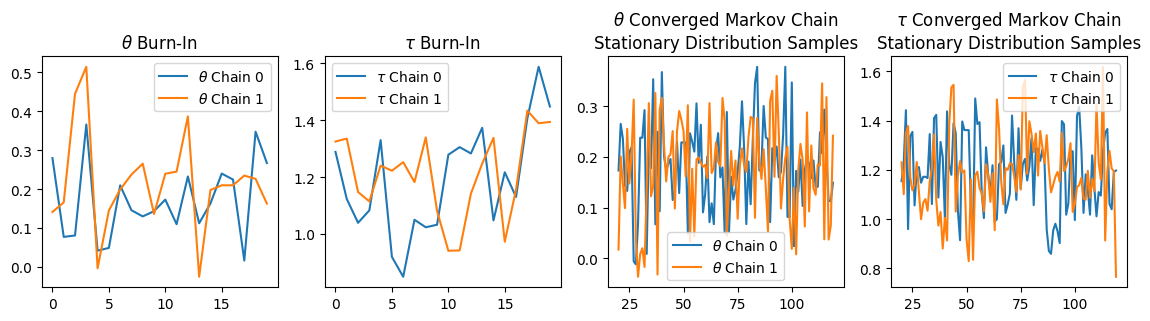

In [10]:
# 提取 posterior（后验分布）中的 theta 和 tau 参数的 MCMC 采样结果
theta = idata.posterior['theta'].values  # theta 样本
tau = idata.posterior['tau'].values      # tau 样本

# 创建 1 行 4 列的子图，分别展示 Burn-In 期和收敛后的 Markov 链样本
fig, ax = plt.subplots(1, 4, figsize=(14, 3))

# 设置子图标题
ax[0].set_title("$\\theta$ Burn-In")  # theta 的 Burn-In 期
ax[1].set_title("$\\tau$ Burn-In")    # tau 的 Burn-In 期
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")  # theta 收敛后的样本
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")    # tau 收敛后的样本

# MCMC 采样设置
burn = 20    # Burn-In 期的样本数量（前 20 次采样）
demo = 120   # 展示 120 个采样点
C = 2        # 链的数量（chains）

# 绘制每条链的采样结果
for c in range(C):
    # 绘制 Burn-In 期的采样轨迹
    ax[0].plot(theta[c, :burn], label="$\\theta$ Chain " + str(c))  # theta 的 Burn-In
    ax[1].plot(tau[c, :burn], label="$\\tau$ Chain " + str(c))      # tau 的 Burn-In

    # 绘制收敛后的 Markov 链样本
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c, burn:demo], label="$\\theta$ Chain " + str(c))  # theta 的收敛样本
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c, burn:demo], label="$\\tau$ Chain " + str(c))      # tau 的收敛样本

# 添加图例
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

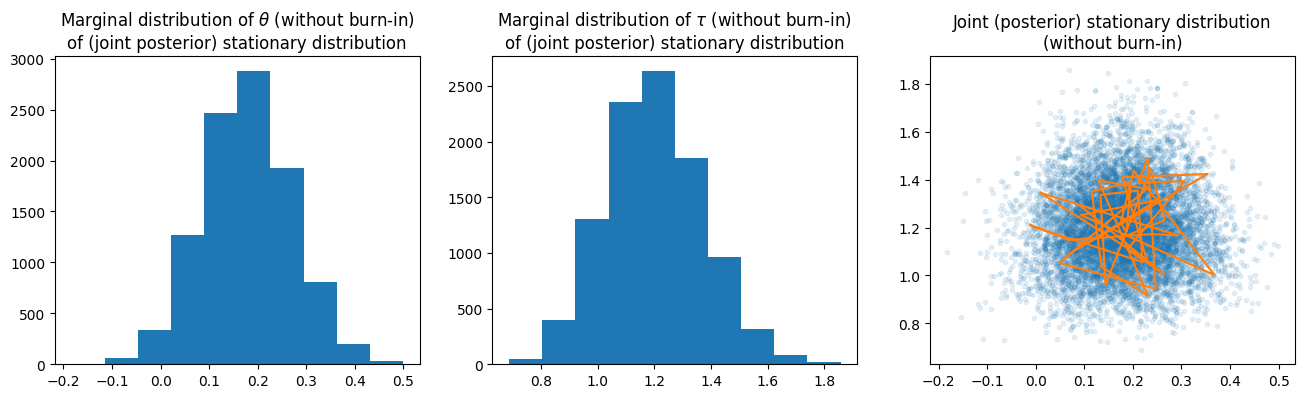

In [11]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

In [12]:
# 导入 ArviZ 库，用于贝叶斯分析的可视化和诊断

import arviz as az

In [13]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

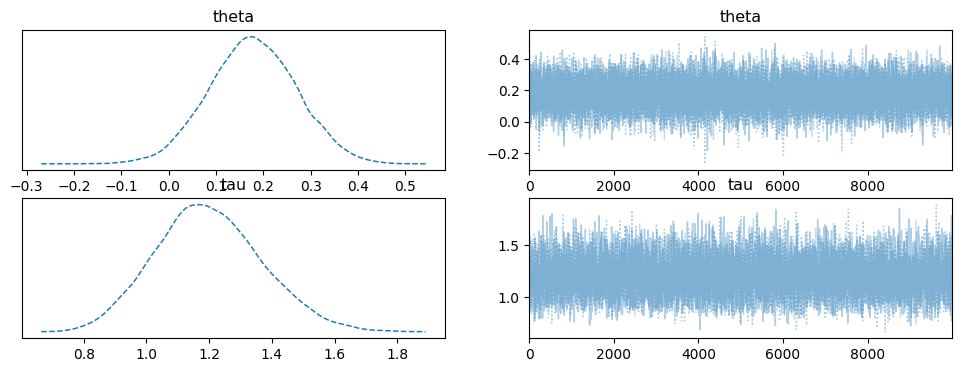

In [14]:
# 使用 ArviZ 绘制 MCMC 采样轨迹图和后验分布
# combined=True 表示将所有 chains 合并在一起进行展示

az.plot_trace(idata, combined=True)

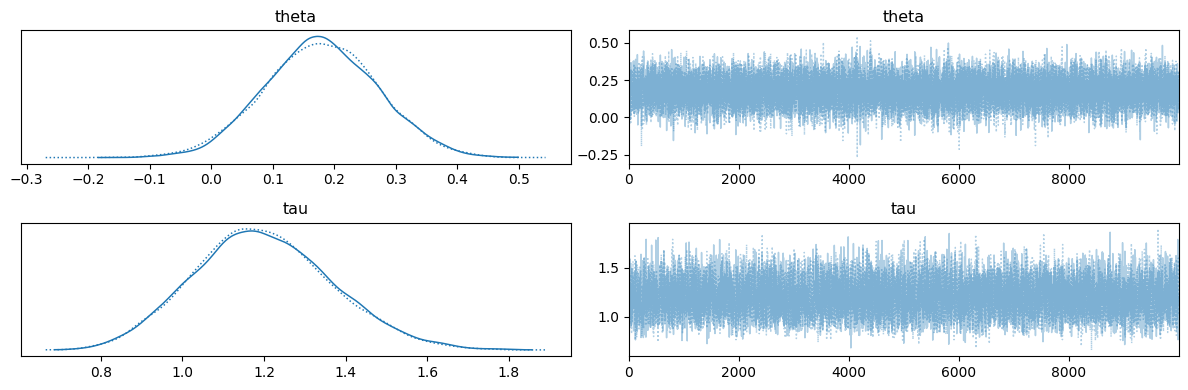

In [15]:
# 使用 ArviZ 绘制 MCMC 采样轨迹图和后验分布
# 不合并 chains，分别展示每条链的采样轨迹
az.plot_trace(idata)

# 自动调整子图布局，避免标签重叠
plt.tight_layout()

In [16]:
# 定义采样数量
m = 1000

# 在 conjugate_normal_gamma 模型中进行 MCMC 采样
with conjugate_normal_gamma:
    # 从后验分布中抽取 m 个样本，使用 2 条链，tune=100 表示每条链前 100 次采样用于调优（Burn-in）
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # 采样结果存储为 arviz.InferenceData 对象，方便后续分析

# 提取 posterior（后验分布）中的 theta 和 tau 参数的采样结果
theta = idata.posterior['theta'].values  # theta 的 MCMC 采样样本
tau = idata.posterior['tau'].values      # tau 的 MCMC 采样样本

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau]


Output()

Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 71 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [17]:
# 如果运行 MCMC 采样时没有显示默认消息，可以使用 logging 模块来启用日志信息 (log messages)
# 这些消息包括 NUTS 采样器的初始化和采样过程

# 导入 logging 模块
import logging  

# 创建 PyMC 的日志记录器
_log = logging.getLogger("pymc")

# 设置日志级别，决定输出的信息内容
# _log.setLevel(logging.NOTSET)   # 输出所有级别的日志（最详细）
_log.setLevel(logging.INFO)        # 输出一般信息，如采样器类型、初始化方法等（常用）
# _log.setLevel(logging.WARNING)   # 仅显示警告信息
# _log.setLevel(logging.ERROR)     # 仅显示错误信息

# 运行采样时，将会看到类似以下信息：
"""
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]
"""

'\nAuto-assigning NUTS sampler...\nInitializing NUTS using jitter+adapt_diag...\nMultiprocess sampling (2 chains in 4 jobs)\nNUTS: [theta, tau]\n'

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

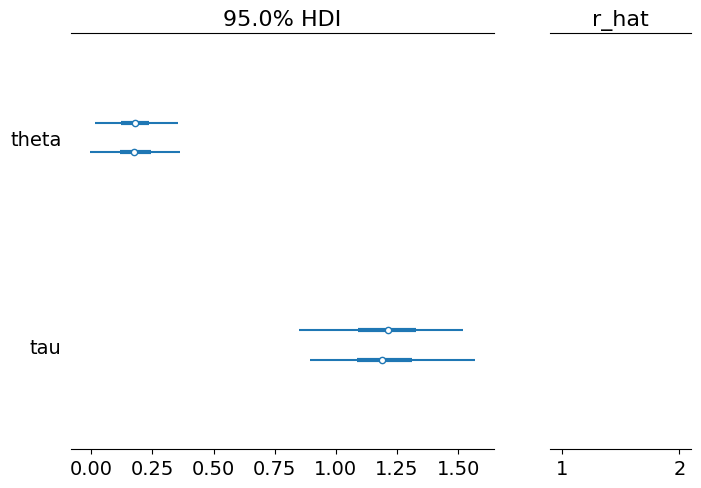

In [18]:
# 使用 ArviZ 绘制森林图（Forest Plot）
# 展示 theta 和 tau 的后验分布及其 95% 高密度区间（HDI）
# 同时显示 R-hat 统计量以评估链的收敛性

az.plot_forest(idata, var_names=["theta", "tau"], 
               combined=False, hdi_prob=0.95, r_hat=True)

## Part B: Posterior inference and diagnostics<br><sub>with `az.summary`</sub>

In [19]:
# 使用 ArviZ 生成后验分布的统计摘要
# idata：MCMC 采样结果的 InferenceData 对象
# round_to=5：将输出结果四舍五入到小数点后 5 位

az.summary(idata, round_to=5)  # 也可以使用 round_to=2 进行四舍五入到 2 位小数

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.17915  0.09129  0.00675  0.34888    0.00190  0.00144  2314.71366   
tau    1.20927  0.17618  0.89461  1.54230    0.00559  0.00397  1003.71927   

         ess_tail    r_hat  
theta  1459.62214  1.00187  
tau    1019.36200  1.00063

In [20]:
# 使用 ravel() 将 theta 数组展平为一维数组
# 然后查看展平后数组的形状（shape）

theta.ravel().shape

(2000,)

### `mean` and `sd`

In [21]:
# 定义保留小数位数
round_to = 5  

# 计算 theta 展平后的一维数组的均值，并四舍五入到 round_to 位小数
# 同时计算 tau 展平后的一维数组的均值，并四舍五入到 round_to 位小数

theta.ravel().mean().round(round_to), tau.ravel().mean().round(round_to)

(0.17915, 1.20927)

In [22]:
# 计算 theta 展平后的一维数组的标准差（总体标准差，ddof=0）
# 同时计算 tau 展平后的一维数组的标准差，结果四舍五入到 round_to 位小数
theta.ravel().std().round(round_to), tau.ravel().std().round(round_to)

# 计算 theta 展平后的一维数组的样本标准差（ddof=1）
# 同时计算 tau 展平后的一维数组的样本标准差，结果四舍五入到 round_to 位小数
theta.ravel().std(ddof=1).round(round_to), tau.ravel().std(ddof=1).round(round_to)

# These are posterior means and standard deviations

(0.09129, 0.17618)

### `hdi_3%` and `hdi_97%`

In [23]:
az.summary(idata, round_to=5)#2)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.17915  0.09129  0.00675  0.34888    0.00190  0.00144  2314.71366   
tau    1.20927  0.17618  0.89461  1.54230    0.00559  0.00397  1003.71927   

         ess_tail    r_hat  
theta  1459.62214  1.00187  
tau    1019.36200  1.00063

In [24]:
# 计算 theta 样本的 5% 和 95% 分位数

np.quantile(theta, [0.05, 0.95]).round(round_to)

array([0.0268 , 0.33397])

In [25]:
np.quantile(theta,[0.025,0.975]).round(round_to)

array([0.0023 , 0.35548])

In [26]:
np.quantile(theta,[0.03,0.97]).round(round_to)

array([0.007 , 0.3489])

In [27]:
# 计算 theta 样本的 2% 和 96% 分位数，近似表示 94% HDI（高密度区间）
# 该方法通过调整区间位置，找到最小的区间范围以覆盖目标概率质量

np.quantile(theta, [0.02, 0.96]).round(round_to)

array([-0.00591,  0.34108])

In [28]:
# 计算 tau 样本的 2.22% 和 96.22% 分位数
# 该方法旨在更接近 tau 的高密度区间（HDI）
# 通过调整分位数，找到覆盖概率质量的最小区间

np.quantile(tau, [0.022, 0.9622]).round(round_to)

array([0.88406, 1.54125])

### To consider `mcse_mean` and `mcse_sd`...

- [...moments of moments and first order Taylor series approximation](https://mc-stan.org/posterior/reference/mcse_sd.html)

In [29]:
# 使用 ArviZ 生成后验分布的统计摘要
# idata：MCMC 采样结果的 InferenceData 对象

az.summary(idata, round_to=5)  

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.17915  0.09129  0.00675  0.34888    0.00190  0.00144  2314.71366   
tau    1.20927  0.17618  0.89461  1.54230    0.00559  0.00397  1003.71927   

         ess_tail    r_hat  
theta  1459.62214  1.00187  
tau    1019.36200  1.00063

In [30]:
# 计算 theta 的标准误（Standard Error, SE）
# SE = 后验分布的标准差（sd）除以有效样本量（ess_bulk）的平方根

# 获取 theta 的标准差（sd）和有效样本量（ess_bulk）
# round_to=5 表示保留 5 位小数
az.summary(idata, round_to=5)['sd']['theta'] / \
az.summary(idata, round_to=5)['ess_bulk']['theta']**0.5

0.0018974684777521439

In [31]:
# 计算 tau 的标准误（Standard Error, SE）
# SE = 后验分布的标准差（sd）除以有效样本量（ess_bulk）的平方根
# 在分母中加上 0 以确保数据类型一致，避免计算错误

az.summary(idata, round_to=5)['sd']['tau'] / \
(az.summary(idata, round_to=5)['ess_bulk']['tau'] + 0)**0.5

0.005560969006834814

In [32]:
# 计算 theta 的方差估计量
# 分子：计算 theta 样本与其均值的偏差平方的方差
# 分母：theta 的有效样本量（ess_bulk）
# 结果表示 theta 样本方差的标准误差估计

((theta.ravel() - theta.ravel().mean())**2).var() / \
az.summary(idata, round_to=5)['ess_bulk']['theta']

5.9582381177911385e-08

In [33]:
# 估计 theta 样本的方差（Y 的估计量）
# 方法 1：计算样本偏差平方的均值
((theta.ravel() - theta.ravel().mean())**2).mean()

# 方法 2：直接计算 theta 的方差
theta.ravel().var()

# 上述结果的平方根即为标准差（s = sqrt(Y)）

# 估计 Y（方差估计量）的方差
# 分子：样本偏差平方的方差
# 分母：theta 的有效样本量（ess_bulk）
((theta.ravel() - theta.ravel().mean())**2).var() / \
az.summary(idata, round_to=5)['ess_bulk']['theta']

# 基于 Delta Method 估计标准差（s）的方差
# var(S) ≈ (1 / sqrt(E[Y]))^2 * Var(Y)
# 其中 E[Y] ≈ theta.ravel().var()
((1 / theta.ravel().var()) * \
 ((theta.ravel() - theta.ravel().mean())**2).var() / \
 az.summary(idata, round_to=15)['ess_bulk']['theta'])**0.5

0.0026745508483659495

In [34]:
# 基于 Delta Method 估计 tau 的标准差（s）的蒙特卡洛标准误差（MCSE）
# var(S) ≈ (1 / sqrt(E[Y]))^2 * Var(Y)
# 其中 E[Y] ≈ tau.ravel().var()

((1 / tau.ravel().var()) * \
 ((tau.ravel() - tau.ravel().mean())**2).var() / \
 az.summary(idata, round_to=15)['ess_bulk']['tau'])**0.5

0.007946878821433778

### We must first consider `bulk_tail` and `ess_tail`...

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [36]:
# 计算 theta 样本中位于两侧 5% 尾部的样本数量
# 左尾：小于或等于 5% 分位数
# 右尾：大于或等于 95% 分位数

theta_in_tail = \
(theta <= np.quantile(theta.ravel(), 0.05)) + \
(theta >= np.quantile(theta.ravel(), 0.95))

# 计算位于两侧尾部样本的比例（总样本数为 2 * m，因有 2 条链）
print(theta_in_tail.sum() / (2 * m))

# 输出位于尾部的样本布尔矩阵（True 表示该样本位于尾部）
theta_in_tail

0.1


array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

1174.2368978456716

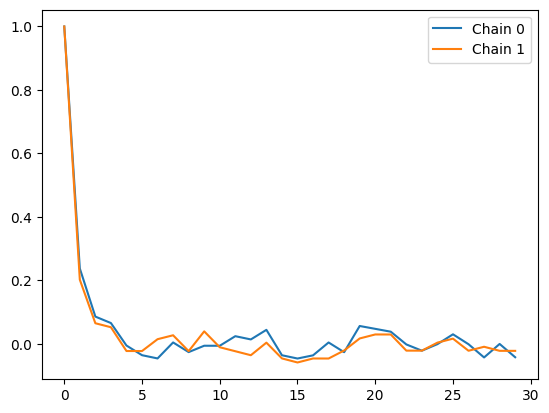

In [37]:
# 定义采样数量和计算自相关系数的最大滞后期
m = 1000
K = 30

# 初始化自相关系数矩阵，维度为 (2, m/2)，初始值为 1
autocorrelations = np.ones((2, int(m / 2)))

# 计算每条链的自相关系数
for c in range(C):  # 遍历两条链
    for t_plus_k in range(1, int(m / 2)):  # 计算滞后 k 的自相关系数
        autocorrelations[c, t_plus_k] = \
        np.corrcoef(theta_in_tail[c, :-t_plus_k], 
                    theta_in_tail[c, t_plus_k:])[0, 1]

# 绘制前 K 个滞后期的自相关系数
for c in range(C):
    plt.plot(autocorrelations[c, :K], label="Chain " + str(c))

# 添加图例
plt.legend()

# 近似有效样本量（Effective Sample Size, ESS）
# approximation_stops 决定计算自相关系数和的终止位置
approximation_stops = [5, 4]

# 计算有效样本量（ESS）
# ESS ≈ m / (1 + 2 * 自相关系数之和)
ess_chain_0 = m / (1 + 2 * autocorrelations[0, 1:approximation_stops[0]].sum())
ess_chain_1 = m / (1 + 2 * autocorrelations[1, 1:approximation_stops[1]].sum())

# 输出 ESS
ess_chain_0 + ess_chain_1

In [38]:
# 查看前 10 个滞后期（lag）的自相关系数
# autocorrelations 的维度为 (2, m/2)，表示两条链在不同滞后期的自相关系数
# [:, :10] 表示取出两条链的前 10 个滞后期的自相关系数

autocorrelations[:, :10]

array([[ 1.        ,  0.23780449,  0.08625736,  0.06594604, -0.00486713,
        -0.03529618, -0.0455295 ,  0.00485317, -0.02558703, -0.00550665],
       [ 1.        ,  0.2024748 ,  0.06530969,  0.05275528, -0.02212655,
        -0.02222612,  0.01507626,  0.02744852, -0.02252615,  0.03972868]])

In [39]:
# 计算 tau 样本中位于两侧 5% 尾部的样本数量
# 左尾：小于或等于 5% 分位数
# 右尾：大于或等于 95% 分位数

tau_in_tail = \
(tau <= np.quantile(tau.ravel(), 0.05)) + \
(tau >= np.quantile(tau.ravel(), 0.95))

# 计算位于两侧尾部样本的比例（总样本数为 2 * m，因有 2 条链）
print(tau_in_tail.sum() / (2 * m))

# 输出位于尾部的样本布尔矩阵（True 表示该样本位于尾部）
tau_in_tail

0.1


array([[False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

1205.3224696754132

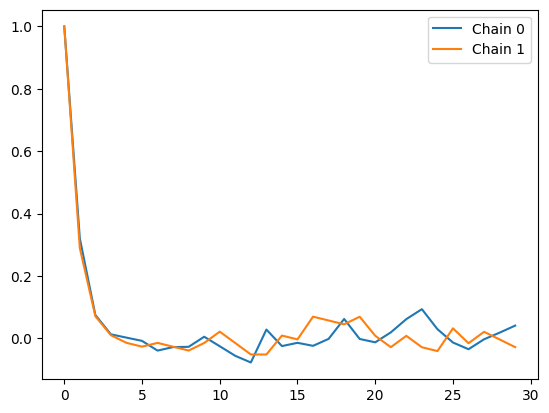

In [40]:
# 定义采样数量和计算自相关系数的最大滞后期
m = 1000
K = 30

# 初始化自相关系数矩阵，维度为 (2, m-1)，初始值为 1
autocorrelations = np.ones((2, m - 1))

# 计算每条链的自相关系数
for c in range(C):  # 遍历两条链
    for t_plus_k in range(1, int(m / 2)):  # 计算滞后 k 的自相关系数
        autocorrelations[c, t_plus_k] = \
        np.corrcoef(tau_in_tail[c, :-t_plus_k], 
                    tau_in_tail[c, t_plus_k:])[0, 1]

# 绘制前 K 个滞后期的自相关系数
for c in range(C):
    plt.plot(autocorrelations[c, :K], label="Chain " + str(c))

# 添加图例
plt.legend()

# 近似有效样本量（Effective Sample Size, ESS）
# approximation_stops 决定计算自相关系数和的终止位置
approximation_stops = [8, 6]

# 计算有效样本量（ESS）
# ESS ≈ m / (1 + 2 * 自相关系数之和)
ess_chain_0 = m / (1 + 2 * autocorrelations[0, 1:approximation_stops[0]].sum())
ess_chain_1 = m / (1 + 2 * autocorrelations[1, 1:approximation_stops[1]].sum())

# 输出 ESS
ess_chain_0 + ess_chain_1

In [41]:
# 查看前 20 个滞后期（lag）的自相关系数
# autocorrelations 的维度为 (2, m-1)，表示两条链在不同滞后期的自相关系数
# [:, :20] 表示取出两条链的前 20 个滞后期的自相关系数

autocorrelations[:, :20]

array([[ 1.        ,  0.32033811,  0.07450028,  0.01233387,  0.0018693 ,
        -0.00859808, -0.03976031, -0.02853107, -0.0276391 ,  0.00469425,
        -0.02582818, -0.056614  , -0.07788169,  0.02769652, -0.0252833 ,
        -0.01483514, -0.02447781, -0.00220289,  0.06168597, -0.0024472 ],
       [ 1.        ,  0.2892068 ,  0.07040274,  0.00954448, -0.01486336,
        -0.0271208 , -0.01506748, -0.02732783, -0.03959086, -0.01537537,
         0.02100647, -0.01558176, -0.05217766, -0.05228517,  0.00844012,
        -0.00382948,  0.06908193,  0.05681565,  0.04454663,  0.0687935 ]])

#### Reminder 

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


2396.993426914344

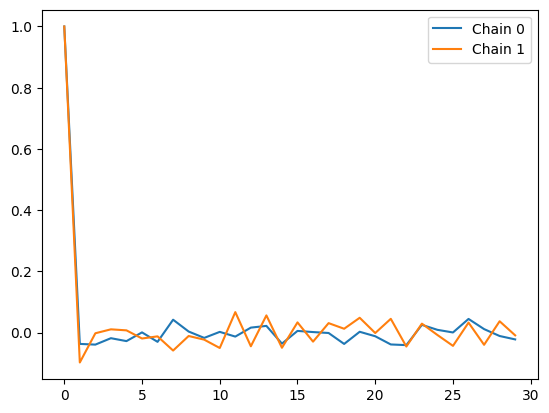

In [42]:
# 定义 sample size（样本量）和最大滞后期（lag）
m = 1000
K = 30

# 初始化 autocorrelations（自相关系数）矩阵，维度为 (2, m/2)，初始值为 1
autocorrelations = np.ones((2, int(m / 2)))

# 计算每条链（chain）的 autocorrelation（自相关系数）
for c in range(C):  # 遍历每条 chain
    for t_plus_k in range(1, int(m / 2)):  # 计算滞后 k 的自相关系数
        autocorrelations[c, t_plus_k] = \
        np.corrcoef(theta[c, :-t_plus_k],  # 当前样本与滞后 k 的样本
                    theta[c, t_plus_k:])[0, 1]  # 计算 Pearson correlation（皮尔逊相关系数）

# 绘制前 K 个滞后期的 autocorrelation（自相关系数）
for c in range(C):
    plt.plot(autocorrelations[c, :K], label="Chain " + str(c))  # 绘制每条 chain 的自相关系数

# 添加图例
plt.legend()

# 计算 effective sample size（有效样本量，ESS）
# approximation_stops 用于控制截断自相关系数的累加范围
approximation_stops = [3, 4]

# ESS ≈ m / (1 + 2 * autocorrelations 的累加和)
# 对两条 chain 分别计算 ESS，再将结果相加
m / (1 + 2 * autocorrelations[0, 1:approximation_stops[0]].sum()) + \
m / (1 + 2 * autocorrelations[1, 1:approximation_stops[1]].sum())



In [ ]:
autocorrelations[:,:10]

994.5145062110123

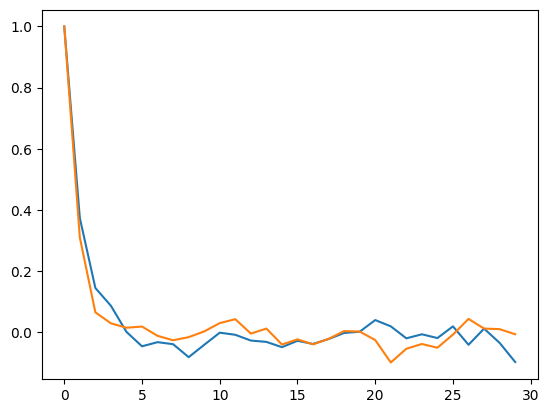

In [43]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau[c,:-t_plus_k], 
                    tau[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,7]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [47]:
autocorrelations[:,:10]

array([[ 1.00000000e+00,  3.73344929e-01,  1.44308425e-01,
         8.60316957e-02,  6.29571942e-04, -4.65466112e-02,
        -3.30303982e-02, -3.95906952e-02, -8.21098947e-02,
        -4.16760088e-02],
       [ 1.00000000e+00,  3.09753880e-01,  6.46448506e-02,
         2.85816225e-02,  1.41899499e-02,  1.80807690e-02,
        -1.23075989e-02, -2.67863310e-02, -1.65871791e-02,
         2.12822439e-03]])

In [46]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.17915  0.09129  0.00675  0.34888    0.00190  0.00144  2314.71366   
tau    1.20927  0.17618  0.89461  1.54230    0.00559  0.00397  1003.71927   

         ess_tail    r_hat  
theta  1459.62214  1.00187  
tau    1019.36200  1.00063

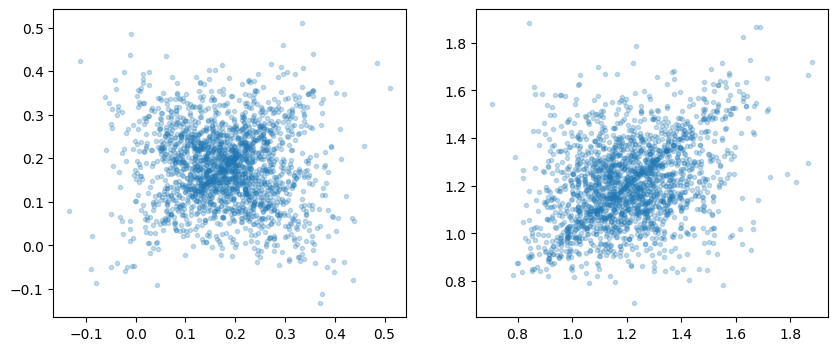

In [48]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(theta.ravel()[:-1], theta.ravel()[1:], '.', alpha=0.25)
ax[1].plot(tau.ravel()[:-1], tau.ravel()[1:], '.', alpha=0.25);

## Part C: R-hat and "energy"

A lack of insufficient "mixing" (agreement) between chains is diagnosed by comparing within and between chain variability. This is done by **checking if the split-$\hat R$ statistic is greater than** $\mathbf{1.05}$. is deemed sufficient when . This is suggestive (but not proof) that the the **Markov chains** have converged to their **stationary distributions**.

> Thus far above we have avoided the notion of "split" chains. Split chains must be considered to ensure that a "drifting chain" does not accidentally pass the $\hat R$ check. Thus the split-$\hat R$ statistic.


$\Large \text{Split-}\hat R  = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $ 

In [44]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
theta  0.17915  0.09129  0.00675  0.34888    0.00190  0.00144  2314.71366   
tau    1.20927  0.17618  0.89461  1.54230    0.00559  0.00397  1003.71927   

         ess_tail    r_hat  
theta  1459.62214  1.00187  
tau    1019.36200  1.00063

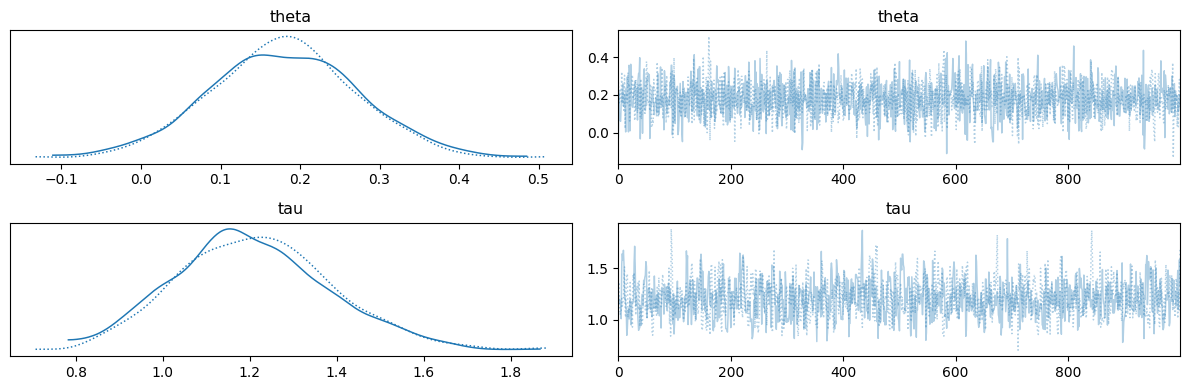

In [45]:
az.plot_trace(idata)
plt.tight_layout()

### Energy

Another diagnostic that sometimes applies is based on the so-called [energy](https://discourse.mc-stan.org/t/help-understanding-bfmi-interpreting-bfmi-1/28554). The exact meaning of "energy" will be discussed next class but for now suffice it to say that when the "Energy transition" fails to dominate the "Marginal energy" the sampler is experiencing a computational bottleneck.


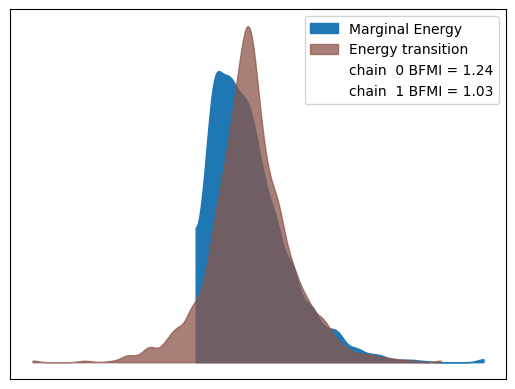

In [49]:
# 使用 ArviZ 绘制 energy plot（能量图）以诊断 MCMC 采样器的性能
# 该图展示 "Energy transition"（能量转移）与 "Marginal energy"（边际能量）之间的关系
# 如果 Energy transition 无法有效覆盖 Marginal energy，说明采样器存在计算瓶颈

az.plot_energy(idata)

## Part D: Samplers


In [ ]:
# 查看 PyMC 中 sample 函数的文档
# 该命令展示 sample 函数的参数、用途和示例
# 用于从后验分布中进行 MCMC 采样，支持多种采样器（如 NUTS、Metropolis 等）

pymc.sample?

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [theta, tau]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.18  0.09    0.01     0.36        0.0      0.0   2349.84   2295.58   
tau    1.19  0.17    0.88     1.50        0.0      0.0   1655.89   2331.80   

       r_hat  
theta    1.0  
tau      1.0

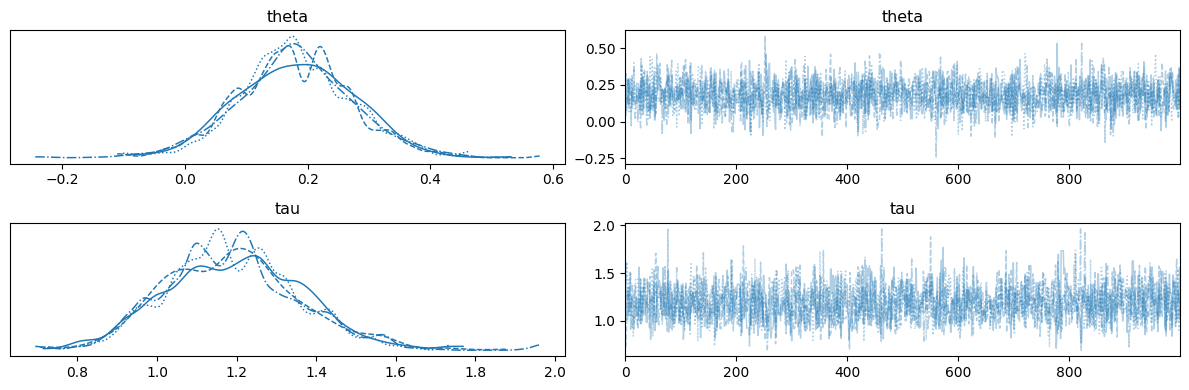

In [51]:
# 在 conjugate_normal_gamma 模型中使用 Hamiltonian Monte Carlo (HMC) 进行采样
with conjugate_normal_gamma:
    HMC = pymc.HamiltonianMC()  # 定义 HMC 采样器
    idata_HMC = pymc.sample(chains=4, step=HMC)  # 使用 4 条链进行 MCMC 采样

# 显示 HMC 采样结果的统计摘要，四舍五入保留 2 位小数
display(az.summary(idata_HMC, round_to=2))

# 绘制 HMC 采样的轨迹图（trace plot），展示采样轨迹和后验分布
az.plot_trace(idata_HMC)

# 自动调整子图布局，避免标签和图例重叠
plt.tight_layout()

In [52]:
# 计算 theta 的 rejection rate（拒绝率）
# 检查连续两次采样的 theta 是否相等，若相等则表示该样本被拒绝
# 对每条链（chain）分别计算拒绝率

# 比较每条链中相邻的 theta 样本是否相等
# idata_HMC.posterior.theta.values[:, :-1] 表示当前样本
# idata_HMC.posterior.theta.values[:, 1:]  表示下一个样本
# 相等为 True，表示拒绝采样，最终取均值得到拒绝率

(idata_HMC.posterior.theta.values[:, :-1] == idata_HMC.posterior.theta.values[:, 1:]).mean(axis=1)

array([0.31831832, 0.35435435, 0.28728729, 0.30930931])

In [53]:
# tau rejection rates
(idata_HMC.posterior.tau.values[:,:-1]==idata_HMC.posterior.tau.values[:,1:]).mean(axis=1)

array([0.31831832, 0.35435435, 0.28728729, 0.30930931])

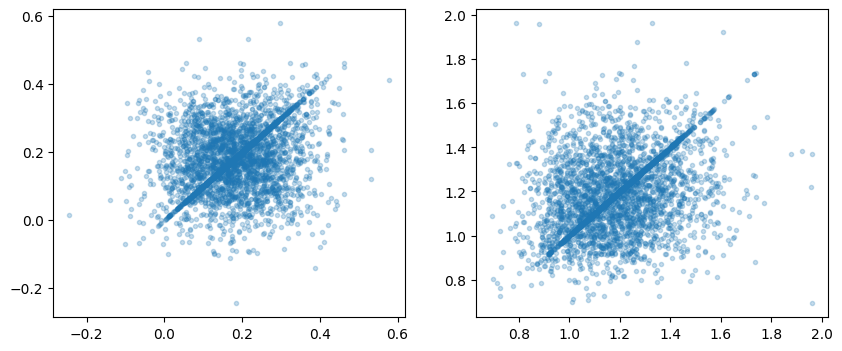

In [54]:
# 创建一个 1 行 2 列的子图，分别用于展示 theta 和 tau 的采样跳跃图（scatter plot）
fig, ax = plt.subplots(1, 2, figsize=(10, 4))  # 设置图表大小为 (10,4)

# 绘制 theta 的跳跃图
# 横轴为当前采样值，纵轴为下一个采样值
# 通过观察点的分布可以判断采样链的混合性和收敛性
ax[0].plot(idata_HMC.posterior.theta.values.ravel()[:-1],  # 当前 theta 样本
           idata_HMC.posterior.theta.values.ravel()[1:],   # 下一个 theta 样本
           '.', alpha=0.25)  # 使用半透明散点图展示（alpha=0.25 增加透明度）

# 绘制 tau 的跳跃图
# 横轴为当前采样值，纵轴为下一个采样值
ax[1].plot(idata_HMC.posterior.tau.values.ravel()[:-1],    # 当前 tau 样本
           idata_HMC.posterior.tau.values.ravel()[1:],     # 下一个 tau 样本
           '.', alpha=0.25)  # 使用半透明散点图展示

# 显示图表
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 184 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.18  0.09    0.01     0.35        0.0      0.0    3026.9   2507.49   
tau    1.20  0.17    0.87     1.50        0.0      0.0    3459.7   2965.28   

       r_hat  
theta    1.0  
tau      1.0

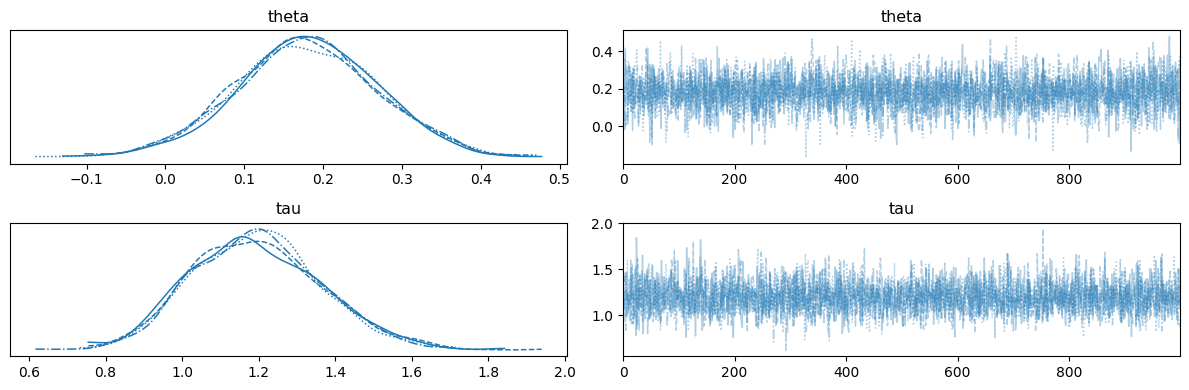

In [56]:
# 在 conjugate_normal_gamma 模型中进行 MCMC 采样
with conjugate_normal_gamma:
    # 运行采样器，使用 4 条链（chains）并设置 target_accept = 0.9
    # target_accept 表示目标接受率，值越高可以降低采样的离散程度，通常用于控制 NUTS 采样器的步长
    idata = pymc.sample(chains=4, target_accept=0.9)

# 显示采样结果的统计摘要
    display(az.summary(idata, round_to=2))

# 绘制采样的轨迹图（trace plot），展示采样轨迹和后验分布
az.plot_trace(idata)

# 自动调整子图布局，避免标签和图例重叠
plt.tight_layout() 

In [57]:
import pandas as pd

# 将采样过程中的 acceptance_rate（接受率）转换为 DataFrame 进行展示
# acceptance_rate 表示每次采样的接受概率，用于评估采样器的性能
display(pd.DataFrame(idata.sample_stats.acceptance_rate))

# 计算 rejection rate（拒绝率）
# 拒绝率 = 1 - 平均接受率（对每条链计算平均值）
1 - idata.sample_stats.acceptance_rate.values.mean(axis=1)

0         1         2         3         4         5        6    \
0  1.000000  0.942225  1.000000  0.612693  1.000000  1.000000  0.90917   
1  0.943209  0.981027  0.945251  0.809688  0.996070  0.545712  1.00000   
2  1.000000  0.816393  0.930933  1.000000  1.000000  0.607523  0.96268   
3  0.986052  0.815097  0.859251  0.950512  0.505773  0.927924  1.00000   

        7         8         9    ...       990       991       992       993  \
0  1.000000  0.962875  1.000000  ...  0.994217  0.705394  0.999365  0.719112   
1  0.994764  0.707624  0.969024  ...  0.979316  0.990623  0.955949  0.845187   
2  0.971629  0.947428  1.000000  ...  0.969115  1.000000  0.961316  0.791807   
3  0.976633  0.825758  0.900757  ...  1.000000  0.920410  0.809367  0.878282   

        994       995       996       997       998       999  
0  1.000000  0.779047  1.000000  0.568484  0.553770  0.957619  
1  1.000000  0.717821  0.994672  0.987727  0.826385  0.986780  
2  0.788639  0.796402  0.779872  1.000000  0.922308  0.997477  
3  1.000000  0.556445  0.971623  1.000000  0.899458  1.000000  

[4 rows x 1000 columns]

array([0.09290888, 0.08129599, 0.08291118, 0.09875813])

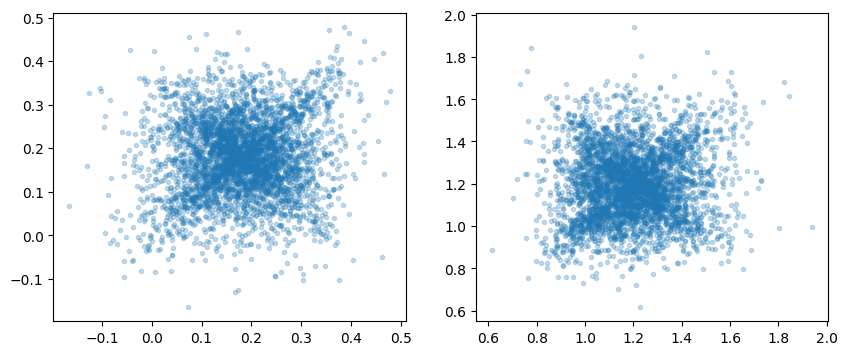

In [58]:
# 创建一个 1 行 2 列的子图，分别用于展示 theta 和 tau 的跳跃图（scatter plot）
fig, ax = plt.subplots(1, 2, figsize=(10, 4))  # 设置图表大小为 (10,4)

# 绘制 theta 的跳跃图
# 横轴为当前采样值，纵轴为下一个采样值
# 通过观察点的分布可以判断采样链的混合性和收敛性
ax[0].plot(idata.posterior.theta.values.ravel()[:-1],  # 当前 theta 样本
           idata.posterior.theta.values.ravel()[1:],   # 下一个 theta 样本
           '.', alpha=0.25)  # 使用半透明散点图展示（alpha=0.25 增加透明度）

# 绘制 tau 的跳跃图
# 横轴为当前采样值，纵轴为下一个采样值
ax[1].plot(idata.posterior.tau.values.ravel()[:-1],    # 当前 tau 样本
           idata.posterior.tau.values.ravel()[1:],     # 下一个 tau 样本
           '.', alpha=0.25)  # 使用半透明散点图展示（alpha=0.25 增加透明度）

# 显示图表
plt.show()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [theta]
>Slice: [tau]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 248 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.18  0.09    0.00     0.35        0.0      0.0   3887.67   2883.33   
tau    1.20  0.17    0.88     1.51        0.0      0.0   3985.46   2905.77   

       r_hat  
theta    1.0  
tau      1.0

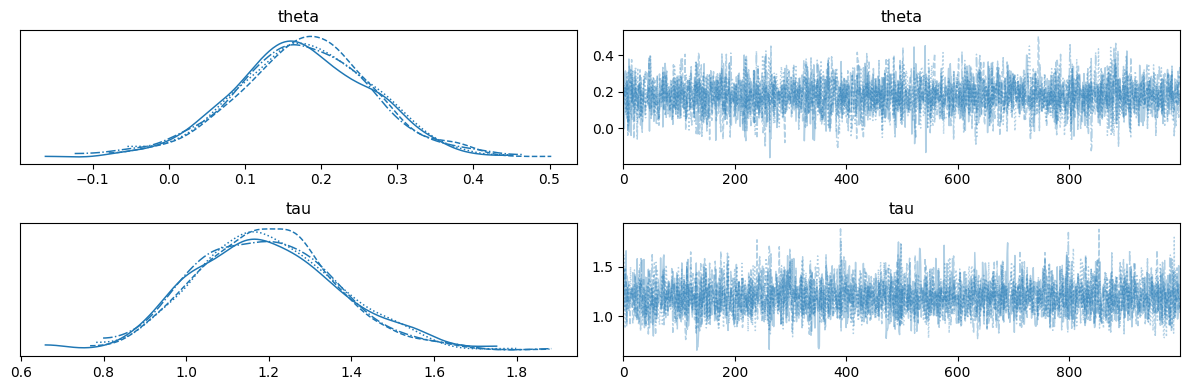

In [59]:
# 在 conjugate_normal_gamma 模型中使用 Slice 采样器进行 MCMC 采样
with conjugate_normal_gamma:
    sampler = pymc.Slice()  # 定义 Slice 采样器
    idata_slice = pymc.sample(step=sampler)  # 运行采样器，默认参数进行采样

    # 显示 Slice 采样结果的统计摘要
    display(az.summary(idata_slice, round_to=2))

# 绘制 Slice 采样的轨迹图（trace plot），展示采样轨迹和后验分布
 az.plot_trace(idata_slice)

# 自动调整子图布局，避免标签和图例重叠
plt.tight_layout()

In [60]:
# theta rejection rates
(idata_slice.posterior.theta.values[:,:-1]==idata_slice.posterior.theta.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

In [61]:
# tau rejection rates
(idata_slice.posterior.tau.values[:,:-1]==idata_slice.posterior.tau.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

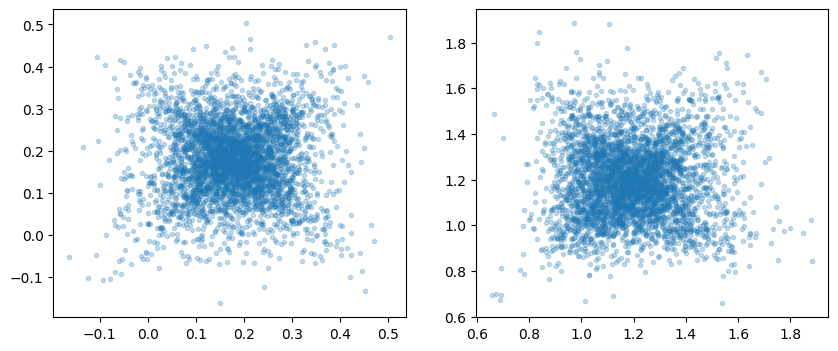

In [62]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_slice.posterior.theta.values.ravel()[:-1], 
           idata_slice.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_slice.posterior.tau.values.ravel()[:-1], 
           idata_slice.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [tau]


Output()

Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 55 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.18  0.09     0.0     0.34       0.00     0.00    356.00    308.45   
tau    1.19  0.18     0.9     1.52       0.01     0.01    468.66    373.03   

       r_hat  
theta   1.01  
tau     1.01

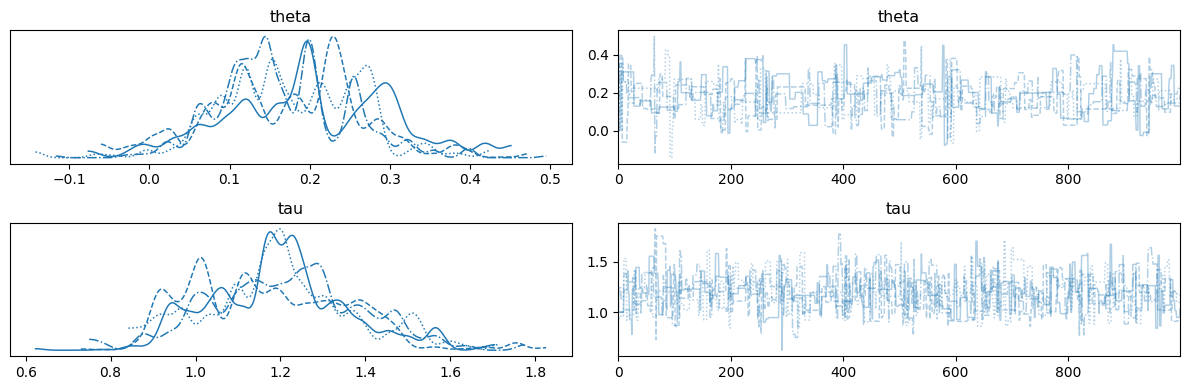

In [63]:
# 在 conjugate_normal_gamma 模型中使用 Metropolis-Hastings (MH) 采样器进行 MCMC 采样
with conjugate_normal_gamma:
    MHv1 = pymc.Metropolis(S=np.ones(1), scaling=1, tune=False)  # 定义 MH 采样器，禁用调优（tune=False）
    idata_MHv1 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv1)  # 运行 4 条链，采样 1000 次，且不进行调优

    # 显示 MH 采样结果的统计摘要
    display(az.summary(idata_MHv1, round_to=2))

# 绘制 MH 采样的轨迹图（trace plot），展示采样轨迹和后验分布
az.plot_trace(idata_MHv1)

# 自动调整子图布局，避免标签和图例重叠
plt.tight_layout()

In [64]:
# theta rejection rates
(idata_MHv1.posterior.theta.values[:,:-1]==idata_MHv1.posterior.theta.values[:,1:]).mean(axis=1)

array([0.88488488, 0.89389389, 0.87387387, 0.88088088])

In [65]:
# tau rejection rates
(idata_MHv1.posterior.tau.values[:,:-1]==idata_MHv1.posterior.tau.values[:,1:]).mean(axis=1)

array([0.8038038 , 0.81281281, 0.82782783, 0.81281281])

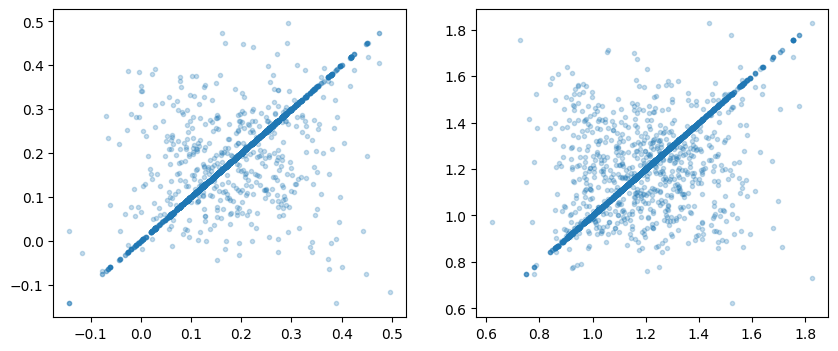

In [66]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv1.posterior.theta.values.ravel()[:-1], 
           idata_MHv1.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv1.posterior.tau.values.ravel()[:-1], 
           idata_MHv1.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [tau]


Output()

Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 40 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.18  0.09    0.00     0.35       0.00     0.00    441.01    462.86   
tau    1.19  0.17    0.87     1.53       0.01     0.01    276.41    358.34   

       r_hat  
theta   1.02  
tau     1.02

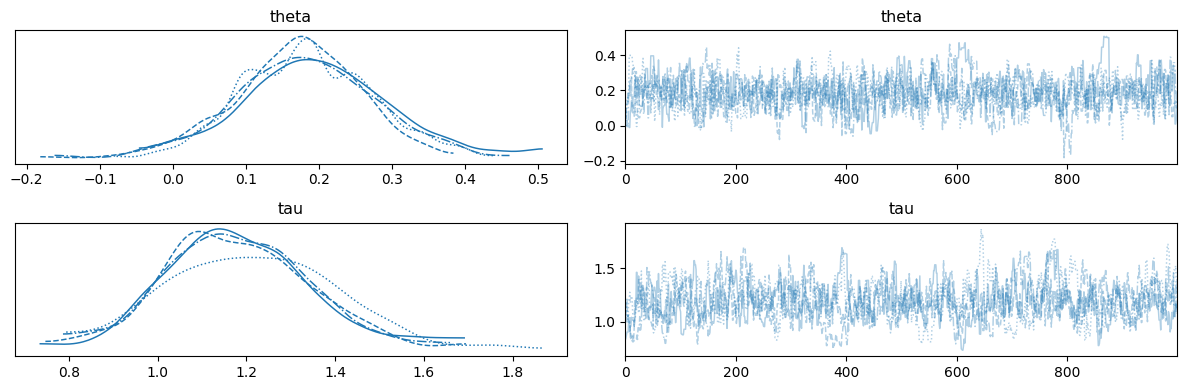

In [67]:
# 在 conjugate_normal_gamma 模型中使用 Metropolis-Hastings (MH) 采样器进行 MCMC 采样
with conjugate_normal_gamma:
    # 定义 MH 采样器，S 为提议分布的协方差矩阵（此处为单位向量），scaling=0.1 控制步长大小，tune=False 禁用调优
    MHv2 = pymc.Metropolis(S=np.ones(1), scaling=0.1, tune=False)
    
    # 运行 4 条链（chains），每条链采样 1000 次（draws），不进行调优（tune=0）
    idata_MHv2 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv2)

# 显示 MH 采样结果的统计摘要，四舍五入保留 2 位小数
display(az.summary(idata_MHv2, round_to=2))

# 绘制 MH 采样的轨迹图（trace plot），展示采样轨迹和后验分布
az.plot_trace(idata_MHv2)

# 自动调整子图布局，避免标签和图例重叠
plt.tight_layout()

In [68]:
# theta rejection rates
(idata_MHv2.posterior.theta.values[:,:-1]==idata_MHv2.posterior.theta.values[:,1:]).mean(axis=1)

array([0.32832833, 0.31431431, 0.33133133, 0.31431431])

In [69]:
# tau rejection rates
(idata_MHv2.posterior.tau.values[:,:-1]==idata_MHv2.posterior.tau.values[:,1:]).mean(axis=1)

array([0.20620621, 0.23723724, 0.21921922, 0.2002002 ])

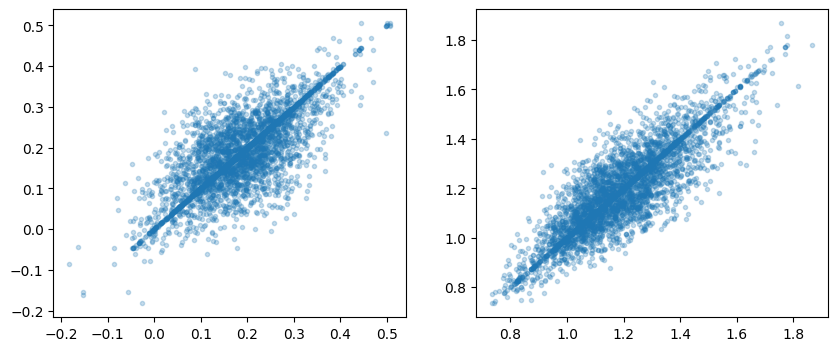

In [70]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv2.posterior.theta.values.ravel()[:-1], 
           idata_MHv2.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv2.posterior.tau.values.ravel()[:-1], 
           idata_MHv2.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

## Week 5 Homework

---

### Q1: Questions about PyMC...

Complete this formatted markdown listing of the contents of "PyMC Example Gallery". *Include links and your favorite image (right click and "copy image address") from each page.*


#### Introductory

- [General Overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Simple Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)
- [General API quickstart](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/ac30f30b2297ec4f2bb798b4f28d2cbba2d0502dbaae4a5f78fdd5cccacda517.svg)|<img src="https://www.pymc.io/projects/docs/en/stable/_images/a8276d1222c43c061dbfff6fa3ff3af15b86038fd7d1e204c429ae3714ea1a20.png"  width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/434538d8660bf2399ebf9df11cbd2b7cec62d8abafc588da625315074b628118.png)|

#### Library Fundamentals

- Distribution Dimensionality
- PyMC and PyTensor
- Using Data Containers

| | | |
|-|-|-|
|1|2|3|


#### Etc.

- 1.
- 2.
- 3.
- 4.
- 5.
- 6.
- 7.
- 8.
- 9.
- 10.
- 11.
- 12.
- 13.


| | | | |
|-|-|-|-|
|1|2|3|4|
|5|6|7|8|
|9|10|11|12|

Etc.


### Q2: Continue "Q2" of the previous weeks 3 and 4

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

### Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 41 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'theta'}>, <Axes: title={'center': 'tau'}>],
      dtype=object)

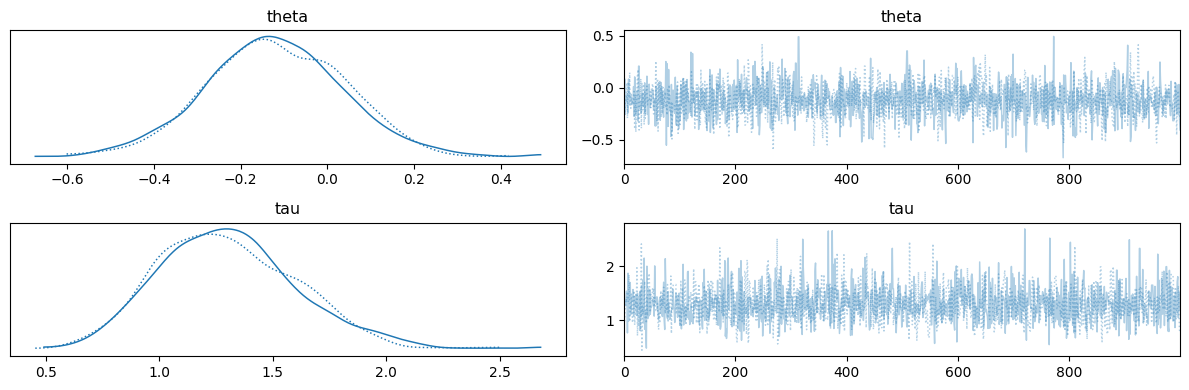

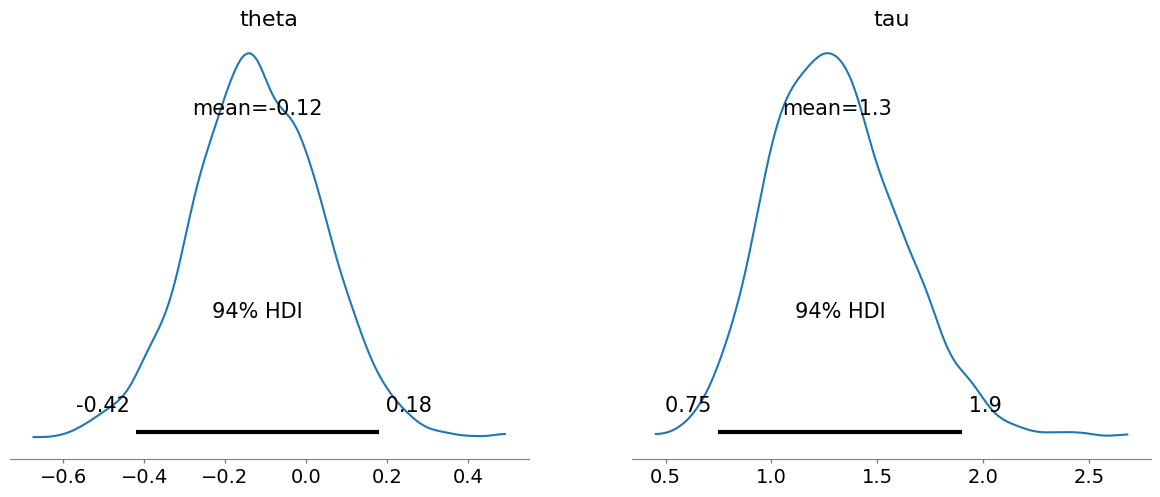

In [74]:
# Q2

import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Generate sample data
n = 30
x = np.random.normal(loc=0, scale=1, size=n)

# 1. Bayesian inference with Normal prior for theta and Gamma prior for tau
with pm.Model() as model1:
    theta = pm.Normal('theta', mu=0, sigma=1)
    tau = pm.Gamma('tau', alpha=2, beta=1)
    x_obs = pm.Normal('x_obs', mu=theta, tau=tau, observed=x)
    idata1 = pm.sample(1000, chains=2, return_inferencedata=True)

# Diagnostic plots for Model 1
az.plot_trace(idata1)
plt.tight_layout()
print(az.summary(idata1))

Initializing NUTS using jitter+adapt_diag...
C:\Users\14379\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': 'theta'}>, <Axes: title={'center': 'tau'}>],
      dtype=object)

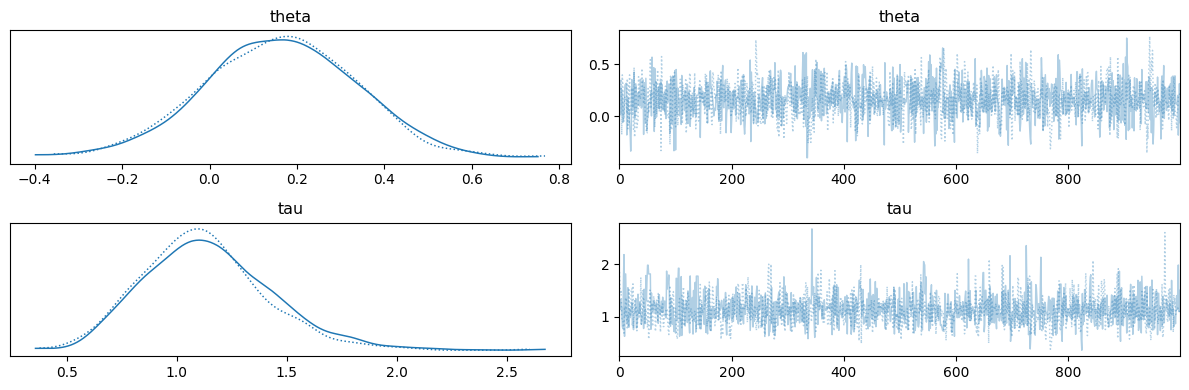

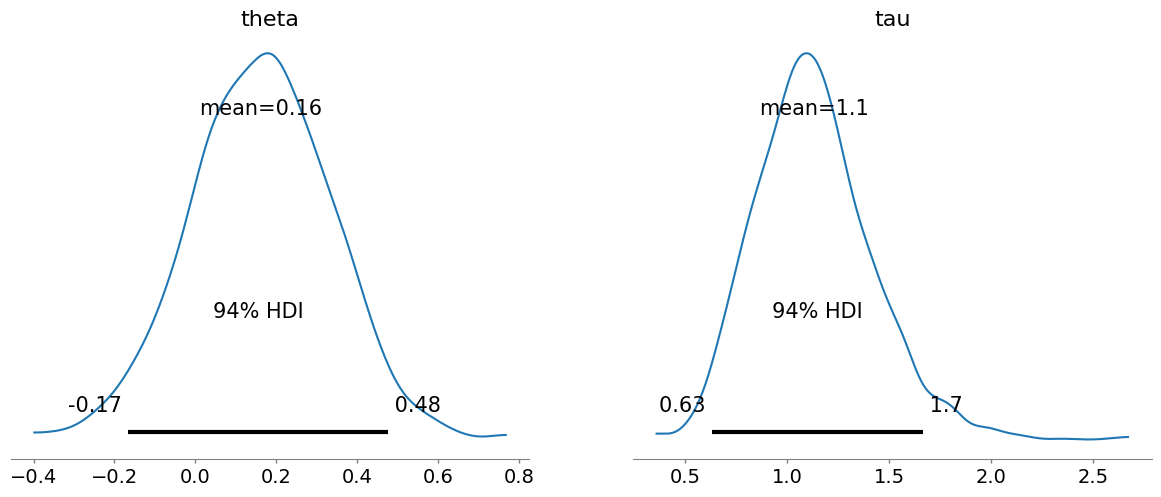

In [72]:
# 2. Bayesian inference with non-Normal prior for theta and non-Gamma prior for tau
with pm.Model() as model2:
    theta = pm.Uniform('theta', lower=-5, upper=5)
    tau = pm.Exponential('tau', lam=1)
    x_obs = pm.Normal('x_obs', mu=theta, tau=tau, observed=x)
    idata2 = pm.sample(1000, chains=2, return_inferencedata=True)

# Diagnostic plots for Model 2
az.plot_trace(idata2)
plt.tight_layout()
print(az.summary(idata2))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.156  0.167  -0.191    0.445      0.004    0.003    1741.0    1251.0   
tau    1.221  0.293   0.691    1.733      0.007    0.005    1751.0    1443.0   

       r_hat  
theta    1.0  
tau      1.0  
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.161  0.173  -0.166    0.477      0.004    0.004    1584.0    1158.0   
tau    1.132  0.286   0.632    1.665      0.008    0.006    1429.0     939.0   

       r_hat  
theta    1.0  
tau      1.0  
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.143  0.195  -0.226    0.507      0.005    0.004    1416.0    1096.0   
tau    0.787  0.116   0.581    0.981      0.003    0.002    1438.0     993.0   

       r_hat  
theta    1.0  
tau      1.0  


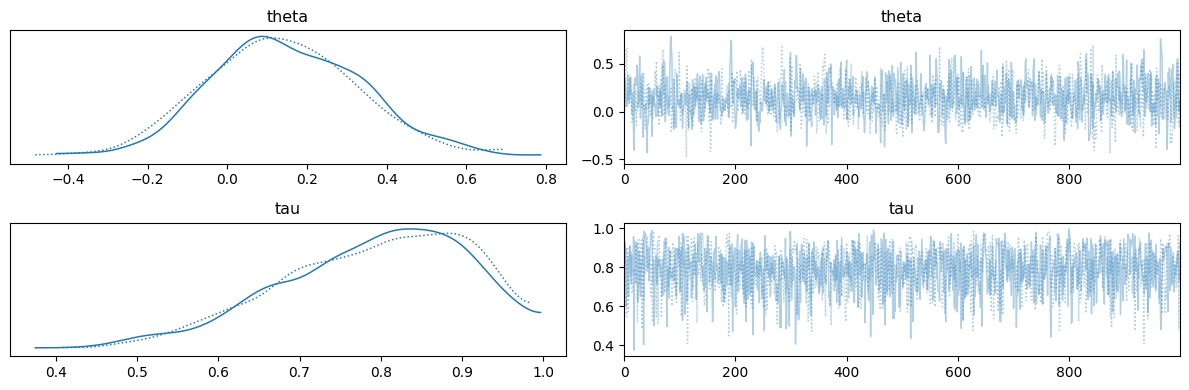

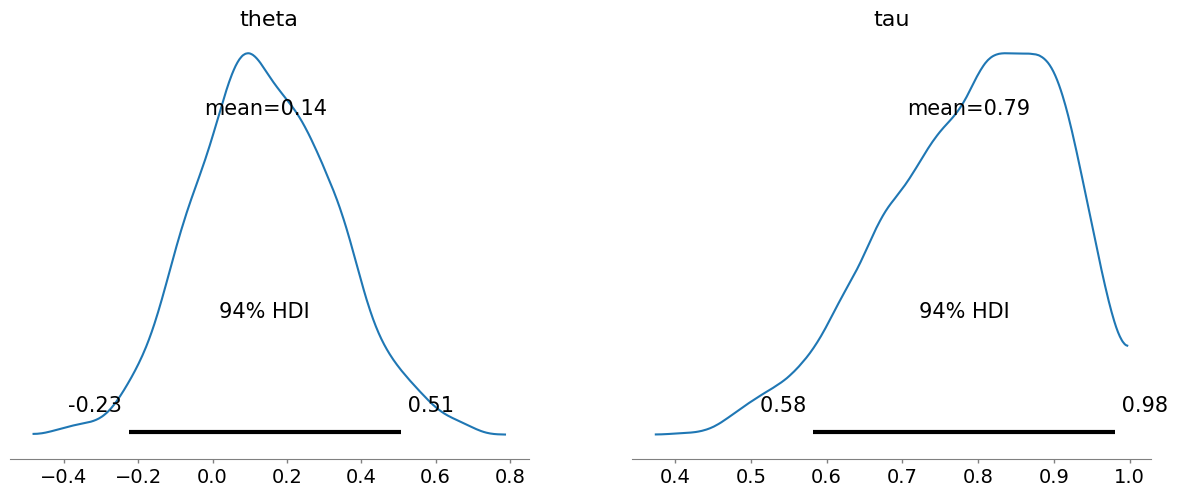

In [73]:
# 3. Bayesian inference with another set of non-Normal and non-Gamma priors
with pm.Model() as model3:
    theta = pm.Laplace('theta', mu=0, b=1)
    tau = pm.Beta('tau', alpha=2, beta=2)
    x_obs = pm.Normal('x_obs', mu=theta, tau=tau, observed=x)
    idata3 = pm.sample(1000, chains=2, return_inferencedata=True)

# Diagnostic plots for Model 3
az.plot_trace(idata3)
plt.tight_layout()

# Summaries
print(az.summary(idata3))

In [ ]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):
    
    # find interval of grid points where f(x_grid) > y 
    # then extend the enterval so endpoints f(a)<y and f(b)<y 
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid
    
    x_ = a + stats.uniform().rvs()*(b-a)    
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f" 
    elif x_ < x:  # or if "x_ was above f on the left side of the interval" 
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):
    
    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)
    
    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


In [ ]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))
    
m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):
    
    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')
    
    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')
    
plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();

# Q3

1. How the Markov Algorithm of Slice Sampling Works:

Slice sampling is a Markov Chain Monte Carlo (MCMC) method used to sample from complex distributions when the normalization constant is unknown. The core idea is to introduce an auxiliary variable and sample uniformly from the region under the probability density curve, known as the "slice."

Steps in the Algorithm:

Define the Target Function `f(x)`: This is the probability density function (PDF) we want to sample from.

Initialization: Start with an initial point `x`.

Vertical Sampling: Draw a vertical coordinate `y` uniformly from `[0, f(x)]`. This defines a horizontal slice under `f(x)`.

Horizontal Sampling (Slice Sampling): Sample a new `x_` uniformly within the horizontal interval where `f(x_) > y`.

If `f(x_) > y`, accept `x_` as the new sample.

If not, shrink the interval and repeat the sampling within the updated interval.

The functions `slice_f_at_y` and `slice_f_at_y_` implement this process. They iteratively shrink the interval until a suitable `x_` is found.

2. Replacing Metropolis-Hastings in Gibbs Sampling:

When using a Metropolis within Gibbs sampler, if the full conditional distributions are known only up to a normalizing constant, slice sampling can be a robust alternative. Here’s how:

Full Conditional Sampling: Instead of proposing a new state and accepting/rejecting (as in Metropolis-Hastings), slice sampling directly samples from the slice defined by the current state.

Defining the Slice: The "curve" we sample beneath is the unnormalized full conditional density.

Initial Value: The current state of the Markov chain serves as the starting point.

Steps for Gibbs with Slice Sampling:

Sample y uniformly from `[0, f(x_current)]`.

Identify the slice: the interval where `f(x) > y`.

Sample uniformly from this slice.

Repeat for each variable in the Gibbs cycle.

3. Explanation of the Code:

`slice_f_at_y` and `slice_f_at_y_`: Implement the slice sampling logic by recursively shrinking the sampling interval.

`f = lambda x: stats.beta(1.5,3).pdf(x)`: Defines the target distribution (Beta distribution).

Sampling Process:

Draw `y` uniformly below `f(x)`.

Find new `x` within the valid slice.

Visualization: The code plots the sampling process and the resulting histogram of samples, demonstrating convergence to the target distribution.

This approach avoids the need for tuning proposal distributions and often provides better mixing for complex target distributions.